In [32]:
%matplotlib inline
from directSolve import DS
from linearSolve import linearSolve_direct
import numpy as np, matplotlib.pyplot as plt
import pystokes
import matelms as me

In [33]:
def rotation(vector,alpha, beta, gamma):
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

## test rotation matrix
vector = np.array([0,0,1])
rotation(vector, np.pi/4, 0, 0)

array([ 0.        , -0.70710678,  0.70710678])

First, try something rather basic. Two squirmers swimming in opposite directions away from each other for a short time...

In [19]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 0.3, 2, 0.1
#ds = DS(b, Np, eta)
ls = linearSolve_direct(b, Np, eta)

S0, D0  = -3/50*1.0, 1.      # strength of the stresslet (V2s) and potDipole (V3t)
forces  = pystokes.forceFields.Forces(particles=Np)

In [29]:
%%time
## Two active particles with orientations in positive z-direction, 
## falling next to each other under gravity: direct solver

#initial position
r = np.array([-1.5*b,1.5*b, 0.,0., 0.,0.])

#initial orientation
#p = np.array([-1.,1., 0.,0., 0.,0.])
#initial orientation: 50 deg towards each other
p0_  = np.array([0., 1., 0.])
p01_ = rotation(p0_, 0., 0., -25*2*np.pi/360)
p02_ = rotation(p0_, 0., 0., 25*2*np.pi/360)
p   = np.zeros(3*Np)
p[::Np]  = p01_
p[1::Np] = p02_

# external force and torque
F = np.array([0.,0., 0.,0., -0.,-0.])
T = np.array([0.,0., 0.,0.,  0., 0.]) 

# integration parameters
Nt=1000; 
r1=np.zeros([3,Nt]); r2=np.zeros([3,Nt])
p1=np.zeros([3,Nt]); p2=np.zeros([3,Nt])

r1[:,0] = r[::Np]; r2[:,0] = r[1::Np]
p1[:,0] = p[::Np]; p2[:,0] = p[1::Np]

dt=0.01;

v = np.zeros(3*Np);
o = np.zeros(3*Np)

theta1=np.zeros([3,Nt]); theta2=np.zeros([3,Nt])

v1 = np.zeros([3,Nt-1]); v2 = np.zeros([3,Nt-1])
o1 = np.zeros([3,Nt-1]); o2 = np.zeros([3,Nt-1])

# initial slip modes
S = np.zeros(5*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yy, yz
    S[i]       = S0*(3*p[i]*p[i] -1)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np]-1)
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

for i in range(Nt-1):
    forces.lennardJones(F,r,lje=2.6,ljr=0.7); ## good parameters?
    #ds.directSolve(v, o, r, F, T, S, D)
    ls.RBM(v, o, r, F, T, S, D)
    
    #position
    r1[:,i+1] = r1[:,i] + dt*v[::Np]
    r2[:,i+1] = r2[:,i] + dt*v[1::Np]
    
    #angle (needed?)
    theta1[:,i+1] = theta1[:,i] + dt*o[::Np]
    theta2[:,i+1] = theta2[:,i] + dt*o[1::Np]
    
    #orientation
    p1[:,i+1] = rotation(p1[:,i], theta1[0,i+1], theta1[1,i+1], theta1[2,i+1])
    p2[:,i+1] = rotation(p2[:,i], theta2[0,i+1], theta2[1,i+1], theta2[2,i+1])
    
    #get velocity (constant for this case)
    v1[:,i] = v[::Np]
    v2[:,i] = v[1::Np]
    
    #get angular velocity (constant for this case)
    o1[:,i] = o[::Np]
    o2[:,i] = o[1::Np]
    
    # reset variables for next time step
    r[::Np] = r1[:,i+1]
    r[1::Np] = r2[:,i+1]
    v = v*0
    o = o*0
    F = F*0
    
    # update slip for new orientation of particles
    S[0]       = S0*(3*p1[0,i+1]*p1[0,i+1] -1)
    S[0 + Np]  = S0*(3*p1[0,i+1]*p1[1,i+1])
    S[0 + 2*Np]= S0*(3*p1[0,i+1]*p1[2,i+1])
    S[0 + 3*Np]= S0*(3*p1[1,i+1]*p1[1,i+1]-1)
    S[0 + 4*Np]= S0*(3*p1[1,i+1]*p1[2,i+1])
    
    S[1]       = S0*(3*p2[0,i+1]*p2[0,i+1] -1)
    S[1 + Np]  = S0*(3*p2[0,i+1]*p2[1,i+1])
    S[1 + 2*Np]= S0*(3*p2[0,i+1]*p2[2,i+1])
    S[1 + 3*Np]= S0*(3*p2[1,i+1]*p2[1,i+1]-1)
    S[1 + 4*Np]= S0*(3*p2[1,i+1]*p2[2,i+1])
    
    D[0]       = D0*p1[0,i+1]
    D[0+Np]    = D0*p1[1,i+1]
    D[0+2*Np]  = D0*p1[2,i+1]
    
    D[1]       = D0*p2[0,i+1]
    D[1+Np]    = D0*p2[1,i+1]
    D[1+2*Np]  = D0*p2[2,i+1]

print('finish')

finish
CPU times: user 6min 57s, sys: 2min 24s, total: 9min 22s
Wall time: 1min 11s


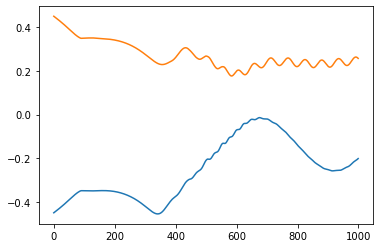

In [30]:
times = np.arange(0,Nt)
plt.plot(times, r1[0,:], times, r2[0,:])

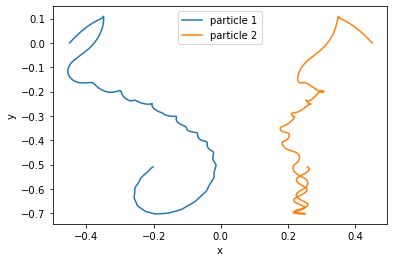

In [31]:
##x-y plot like in Ishikawa
plt.plot(r1[0,:], r1[1,:], label='particle 1')
plt.plot(r2[0,:], r1[1,:], label='particle 2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

__________

Simulate ex3-crystalNucleation and see whether they behave somewhat correctly, although the latter is near a wall..



First: <font size="5">PyStokes
    
    Two active particles at a distance 5 times b, with orientation in negative z-direction. Only V^(3t) is active

In [6]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1
pstk = pystokes.unbounded.Rbm(b, Np, eta)

S0, D0  = 0., 2.0      # strength of the stresslet (V2s) and potDipole (V3t)
forces  = pystokes.forceFields.Forces(particles=Np)

In [7]:
%%time
## Two active particles with orientations in positive z-direction, 
## falling next to each other under gravity: direct solver

#initial position
r = np.array([-2.5,2.5, 0,0 , 2.5, 2.5])

#initial orientation
p = np.array([0,0, 0,0, -1.0,-1.0])

# external force and torque
F = np.zeros(3*Np)
T = np.array([0.,0., 0.,0.,  0., 0.]) 

vs = 0.4
F0 = 6*np.pi*eta*b*vs*(1+9*b/(8*r[4])); #active stall force -- what is this?? in pystokes V^A=1/5*V^(3t) is missing

# integration parameters
Nt=2**16; 
r1=np.zeros([3,Nt]); r2=np.zeros([3,Nt])
p1=np.zeros([3,Nt]); p2=np.zeros([3,Nt])

r1[:,0] = r[::Np]; r2[:,0] = r[1::Np]
p1[:,0] = p[::Np]; p2[:,0] = p[1::Np]

dt=0.01;

v = np.zeros(3*Np);
o = np.zeros(3*Np)

theta1=np.zeros([3,Nt]); theta2=np.zeros([3,Nt])

v1 = np.zeros([3,Nt-1]); v2 = np.zeros([3,Nt-1])
o1 = np.zeros([3,Nt-1]); o2 = np.zeros([3,Nt-1])

# initial slip modes
S = np.zeros(5*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yy, yz
    S[i]       = S0*(3*p[i]*p[i] -1)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np]-1)
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

for i in range(Nt-1):
    forces.lennardJones(F,r,lje=.6,ljr=2.1); F[4],F[5]= F0, F0
    pstk.mobilityTT(v,r,F)
    pstk.mobilityTR(v,r,T)
    pstk.mobilityRT(o,r,F)
    pstk.mobilityRR(o,r,T)
    pstk.propulsionT3t(v,r,D)
    
    #position
    r1[:,i+1] = r1[:,i] + dt*v[::Np]
    r2[:,i+1] = r2[:,i] + dt*v[1::Np]
    
    #angle (needed?)
    theta1[:,i+1] = theta1[:,i] + dt*o[::Np]
    theta2[:,i+1] = theta2[:,i] + dt*o[1::Np]
    
    #orientation
    p1[:,i+1] = rotation(p1[:,i], theta1[0,i+1], theta1[1,i+1], theta1[2,i+1])
    p2[:,i+1] = rotation(p2[:,i], theta2[0,i+1], theta2[1,i+1], theta2[2,i+1])
    
    #get velocity (constant for this case)
    v1[:,i] = v[::Np]
    v2[:,i] = v[1::Np]
    
    #get angular velocity (constant for this case)
    o1[:,i] = o[::Np]
    o2[:,i] = o[1::Np]
    
    # reset variables for next time step
    r[::Np] = r1[:,i+1]
    r[1::Np] = r2[:,i+1]
    v = v*0
    o = o*0
    F[0:3] = F[0:3]*0 
    
    # update slip for new orientation of particles
    S[0]       = S0*(3*p1[0,i+1]*p1[0,i+1] -1)
    S[0 + Np]  = S0*(3*p1[0,i+1]*p1[1,i+1])
    S[0 + 2*Np]= S0*(3*p1[0,i+1]*p1[2,i+1])
    S[0 + 3*Np]= S0*(3*p1[1,i+1]*p1[1,i+1]-1)
    S[0 + 4*Np]= S0*(3*p1[1,i+1]*p1[2,i+1])
    
    S[1]       = S0*(3*p2[0,i+1]*p2[0,i+1] -1)
    S[1 + Np]  = S0*(3*p2[0,i+1]*p2[1,i+1])
    S[1 + 2*Np]= S0*(3*p2[0,i+1]*p2[2,i+1])
    S[1 + 3*Np]= S0*(3*p2[1,i+1]*p2[1,i+1]-1)
    S[1 + 4*Np]= S0*(3*p2[1,i+1]*p2[2,i+1])
    
    D[0]       = D0*p1[0,i+1]
    D[0+Np]    = D0*p1[1,i+1]
    D[0+2*Np]  = D0*p1[2,i+1]
    
    D[1]       = D0*p2[0,i+1]
    D[1+Np]    = D0*p2[1,i+1]
    D[1+2*Np]  = D0*p2[2,i+1]

print('finish')

finish
CPU times: user 5min 7s, sys: 26.2 s, total: 5min 33s
Wall time: 49.4 s


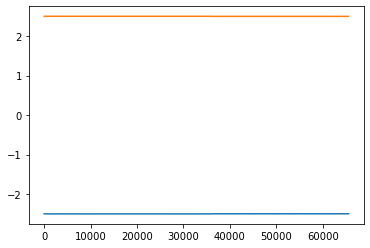

In [8]:
times = np.arange(0,Nt)
plt.plot(times, r1[0,:], times, r2[0,:])

In [9]:
## what's the nearest they come to each other?
np.amin(np.abs(r1[0,:]-r2[0,:]))

4.997838113794825

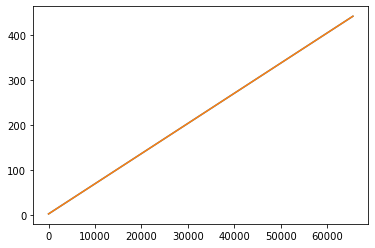

In [10]:
plt.plot(times, r1[2,:], times, r2[2,:])

Not much seems to happen within the time scale plotted here. As shown in ex3, close to an interface the particles come together

_____________________


Test the same system with 

<font size="5">directSolve
    
    Two active particles at a distance 5 times b with orientation in negative z-direction. Only V^(3t) is active

In [11]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1
ds = DS(b, Np, eta)

S0, D0  = 0., 2.0      # strength of the stresslet (V2s) and potDipole (V3t)
forces  = pystokes.forceFields.Forces(particles=Np)

In [12]:
%%time
## Two active particles with orientations in positive z-direction, 
## falling next to each other under gravity: direct solver

#initial position
r = np.array([-2.5,2.5, 0,0 , 2.5, 2.5])

#initial orientation
p = np.array([0,0, 0,0, -1.0,-1.0])

# external force and torque
F = np.zeros(3*Np)
T = np.array([0.,0., 0.,0.,  0., 0.]) 

#vs = 0.4
#F0 = 6*np.pi*eta*b*vs*(1+9*b/(8*r[4])); #active stall force -- what is this??

# integration parameters
Nt=2**16; 
r1=np.zeros([3,Nt]); r2=np.zeros([3,Nt])
p1=np.zeros([3,Nt]); p2=np.zeros([3,Nt])

r1[:,0] = r[::Np]; r2[:,0] = r[1::Np]
p1[:,0] = p[::Np]; p2[:,0] = p[1::Np]

dt=0.01;

v = np.zeros(3*Np);
o = np.zeros(3*Np)

theta1=np.zeros([3,Nt]); theta2=np.zeros([3,Nt])

v1 = np.zeros([3,Nt-1]); v2 = np.zeros([3,Nt-1])
o1 = np.zeros([3,Nt-1]); o2 = np.zeros([3,Nt-1])

# initial slip modes
S = np.zeros(5*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yy, yz
    S[i]       = S0*(3*p[i]*p[i] -1)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np]-1)
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

for i in range(Nt-1):
    forces.lennardJones(F,r,lje=.6,ljr=2.1); #F[4],F[5]= F0, F0
    ds.directSolve(v, o, r, F, T, S, D)
    
    #position
    r1[:,i+1] = r1[:,i] + dt*v[::Np]
    r2[:,i+1] = r2[:,i] + dt*v[1::Np]
    
    #angle (needed?)
    theta1[:,i+1] = theta1[:,i] + dt*o[::Np]
    theta2[:,i+1] = theta2[:,i] + dt*o[1::Np]
    
    #orientation
    p1[:,i+1] = rotation(p1[:,i], theta1[0,i+1], theta1[1,i+1], theta1[2,i+1])
    p2[:,i+1] = rotation(p2[:,i], theta2[0,i+1], theta2[1,i+1], theta2[2,i+1])
    
    #get velocity (constant for this case)
    v1[:,i] = v[::Np]
    v2[:,i] = v[1::Np]
    
    #get angular velocity (constant for this case)
    o1[:,i] = o[::Np]
    o2[:,i] = o[1::Np]
    
    # reset variables for next time step
    r[::Np] = r1[:,i+1]
    r[1::Np] = r2[:,i+1]
    v = v*0
    o = o*0
    F = F*0 
    
    # update slip for new orientation of particles
    S[0]       = S0*(3*p1[0,i+1]*p1[0,i+1] -1)
    S[0 + Np]  = S0*(3*p1[0,i+1]*p1[1,i+1])
    S[0 + 2*Np]= S0*(3*p1[0,i+1]*p1[2,i+1])
    S[0 + 3*Np]= S0*(3*p1[1,i+1]*p1[1,i+1]-1)
    S[0 + 4*Np]= S0*(3*p1[1,i+1]*p1[2,i+1])
    
    S[1]       = S0*(3*p2[0,i+1]*p2[0,i+1] -1)
    S[1 + Np]  = S0*(3*p2[0,i+1]*p2[1,i+1])
    S[1 + 2*Np]= S0*(3*p2[0,i+1]*p2[2,i+1])
    S[1 + 3*Np]= S0*(3*p2[1,i+1]*p2[1,i+1]-1)
    S[1 + 4*Np]= S0*(3*p2[1,i+1]*p2[2,i+1])
    
    D[0]       = D0*p1[0,i+1]
    D[0+Np]    = D0*p1[1,i+1]
    D[0+2*Np]  = D0*p1[2,i+1]
    
    D[1]       = D0*p2[0,i+1]
    D[1+Np]    = D0*p2[1,i+1]
    D[1+2*Np]  = D0*p2[2,i+1]

print('finish')

finish
CPU times: user 1h 11min 8s, sys: 9.43 s, total: 1h 11min 17s
Wall time: 9min 15s


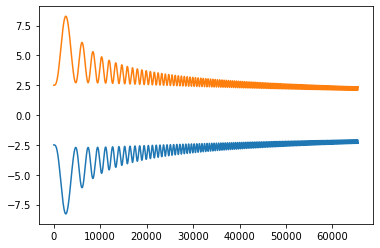

In [13]:
times = np.arange(0,Nt)
plt.plot(times, r1[0,:], times, r2[0,:])

In [14]:
## what's the nearest they come to each other?
np.amin(np.abs(r1[0,:]-r2[0,:]))

4.145286917867604

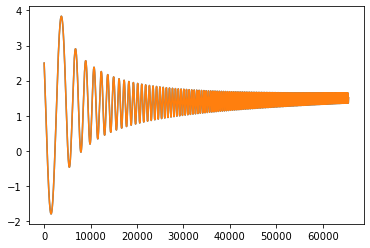

In [15]:
plt.plot(times, r1[2,:], times, r2[2,:])

Active particles with V^(3t) mode only seem to 'dance' with each other and get trapped in some sort of circling - is that physical??

______________





<font size="5">PyStokes
    
    Introduce additional V^(2s) mode and test what a squirmer does: -3/50xV2s + V3t 
    
    
<font size="3">NB: Pystokes definition of elements of V2s is different from mine! Pystokes: xx, yy, xy, xz, yz/ mine: xx, xy, xz, yy, yz
    
    change yy from position 4 to position 2 below!


In [16]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1
pstk = pystokes.unbounded.Rbm(b, Np, eta)

## squirmer
S0, D0  = -3./50.*2.0, 2.0      # strength of the stresslet (V2s) and potDipole (V3t)
forces  = pystokes.forceFields.Forces(particles=Np)

In [17]:
%%time
## Two active particles with orientations in positive z-direction, 
## falling next to each other under gravity: direct solver

#initial position
r = np.array([-2.5,2.5, 0,0 , 2.5, 2.5])

#initial orientation
p = np.array([0,0, 0,0, -1.0,-1.0])

# external force and torque
F = np.zeros(3*Np)
T = np.array([0.,0., 0.,0.,  0., 0.]) 

vs = 0.4
F0 = 6*np.pi*eta*b*vs*(1+9*b/(8*r[4])); #active stall force -- what is this??

# integration parameters
Nt=2**16; 
r1=np.zeros([3,Nt]); r2=np.zeros([3,Nt])
p1=np.zeros([3,Nt]); p2=np.zeros([3,Nt])

r1[:,0] = r[::Np]; r2[:,0] = r[1::Np]
p1[:,0] = p[::Np]; p2[:,0] = p[1::Np]

dt=0.01;

v = np.zeros(3*Np);
o = np.zeros(3*Np)

theta1=np.zeros([3,Nt]); theta2=np.zeros([3,Nt])

v1 = np.zeros([3,Nt-1]); v2 = np.zeros([3,Nt-1])
o1 = np.zeros([3,Nt-1]); o2 = np.zeros([3,Nt-1])

# initial slip modes
S = np.zeros(5*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yy, yz
    S[i]       = S0*(3*p[i]*p[i] -1)
    S[i + 2*Np]  = S0*(3*p[i]*p[i+Np]) ##different ordering in pystokes!
    S[i + 3*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + Np]= S0*(3*p[i+Np]*p[i+Np]-1)
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

for i in range(Nt-1):
    forces.lennardJones(F,r,lje=.6,ljr=2.1); F[4],F[5]= F0, F0
    pstk.mobilityTT(v,r,F)
    pstk.mobilityTR(v,r,T)
    pstk.mobilityRT(o,r,F)
    pstk.mobilityRR(o,r,T)
    pstk.propulsionT3t(v,r,D)
    pstk.propulsionT2s(v,r,S)
    pstk.propulsionR2s(o,r,S)
    
    #position
    r1[:,i+1] = r1[:,i] + dt*v[::Np]
    r2[:,i+1] = r2[:,i] + dt*v[1::Np]
    
    #angle (needed?)
    theta1[:,i+1] = theta1[:,i] + dt*o[::Np]
    theta2[:,i+1] = theta2[:,i] + dt*o[1::Np]
    
    #orientation
    p1[:,i+1] = rotation(p1[:,i], theta1[0,i+1], theta1[1,i+1], theta1[2,i+1])
    p2[:,i+1] = rotation(p2[:,i], theta2[0,i+1], theta2[1,i+1], theta2[2,i+1])
    
    #get velocity (constant for this case)
    v1[:,i] = v[::Np]
    v2[:,i] = v[1::Np]
    
    #get angular velocity (constant for this case)
    o1[:,i] = o[::Np]
    o2[:,i] = o[1::Np]
    
    # reset variables for next time step
    r[::Np] = r1[:,i+1]
    r[1::Np] = r2[:,i+1]
    v = v*0
    o = o*0
    F[0:3] = F[0:3]*0 
    
    # update slip for new orientation of particles
    S[0]       = S0*(3*p1[0,i+1]*p1[0,i+1] -1)
    S[0 + 2*Np]  = S0*(3*p1[0,i+1]*p1[1,i+1])
    S[0 + 3*Np]= S0*(3*p1[0,i+1]*p1[2,i+1])
    S[0 + Np]= S0*(3*p1[1,i+1]*p1[1,i+1]-1)
    S[0 + 4*Np]= S0*(3*p1[1,i+1]*p1[2,i+1])
    
    S[1]       = S0*(3*p2[0,i+1]*p2[0,i+1] -1)
    S[1 + 2*Np]  = S0*(3*p2[0,i+1]*p2[1,i+1])
    S[1 + 3*Np]= S0*(3*p2[0,i+1]*p2[2,i+1])
    S[1 + Np]= S0*(3*p2[1,i+1]*p2[1,i+1]-1)
    S[1 + 4*Np]= S0*(3*p2[1,i+1]*p2[2,i+1])
    
    D[0]       = D0*p1[0,i+1]
    D[0+Np]    = D0*p1[1,i+1]
    D[0+2*Np]  = D0*p1[2,i+1]
    
    D[1]       = D0*p2[0,i+1]
    D[1+Np]    = D0*p2[1,i+1]
    D[1+2*Np]  = D0*p2[2,i+1]

print('finish')

finish
CPU times: user 6min 40s, sys: 33.4 s, total: 7min 13s
Wall time: 1min 4s


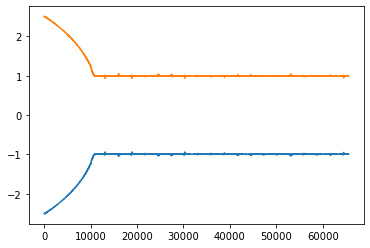

In [18]:
times = np.arange(0,Nt)
plt.plot(times, r1[0,:], times, r2[0,:])

In [19]:
## what's the nearest they come to each other?
np.amin(np.abs(r1[0,:]-r2[0,:]))

1.8711763788554816

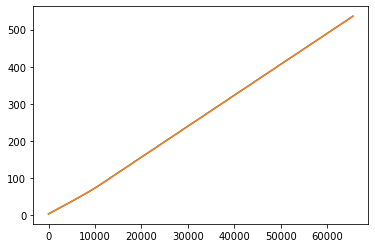

In [20]:
plt.plot(times, r1[2,:], times, r2[2,:])

Seems sensible, particles attract each other until they touch, which is when LJ force keeps them separate.

______________





<font size="5">directSolve
    
    Introduce additional V^(2s) mode and test what a squirmer does: -3/50xV2s + V3t 

In [21]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1
ds = DS(b, Np, eta)

## squirmer
S0, D0  = -3/50*2.0, 2.0      # beta = 1 (positive beta is a puller (negative V2s))
forces  = pystokes.forceFields.Forces(particles=Np)

In [22]:
%%time
## Two active particles with orientations in positive z-direction, 
## falling next to each other under gravity: direct solver

#initial position
r = np.array([-2.5,2.5, 0,0 , 2.5, 2.5])

#initial orientation: 50 deg towards each other (Ishikawa's paper)
#p0=np.array([0., 1., 0.])
#p01 = rotation(p0, 0., 0., -25*2*np.pi/360)
#p02 = rotation(p0, 0., 0., 25*2*np.pi/360)
#p = np.zeros(3*Np)
#p[::Np]  = p01
#p[1::Np] = p02
p = np.array([0,0, 0,0, -1.0,-1.0])

# external force and torque
F = np.zeros(3*Np)
T = np.array([0.,0., 0.,0.,  0., 0.]) 

#vs = 0.4
#F0 = 6*np.pi*eta*b*vs*(1+9*b/(8*r[4])); #active stall force -- what is this??

# integration parameters
Nt=2**16; 
r1=np.zeros([3,Nt]); r2=np.zeros([3,Nt])
p1=np.zeros([3,Nt]); p2=np.zeros([3,Nt])

r1[:,0] = r[::Np]; r2[:,0] = r[1::Np]
p1[:,0] = p[::Np]; p2[:,0] = p[1::Np]

dt=0.01;

v = np.zeros(3*Np);
o = np.zeros(3*Np)

theta1=np.zeros([3,Nt]); theta2=np.zeros([3,Nt])

v1 = np.zeros([3,Nt-1]); v2 = np.zeros([3,Nt-1])
o1 = np.zeros([3,Nt-1]); o2 = np.zeros([3,Nt-1])

# initial slip modes
S = np.zeros(5*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yy, yz
    S[i]       = S0*(3*p[i]*p[i] -1)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np]-1)
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

for i in range(Nt-1):
    forces.lennardJones(F,r,lje=.6,ljr=2.1); #F[4],F[5]= F0, F0, do not actually need this with full solver?
    ds.directSolve(v, o, r, F, T, S, D)
    
    #position
    r1[:,i+1] = r1[:,i] + dt*v[::Np]
    r2[:,i+1] = r2[:,i] + dt*v[1::Np]
    
    #angle (needed?)
    theta1[:,i+1] = theta1[:,i] + dt*o[::Np]
    theta2[:,i+1] = theta2[:,i] + dt*o[1::Np]
    
    #orientation
    p1[:,i+1] = rotation(p1[:,i], theta1[0,i+1], theta1[1,i+1], theta1[2,i+1])
    p2[:,i+1] = rotation(p2[:,i], theta2[0,i+1], theta2[1,i+1], theta2[2,i+1])
    
    #get velocity (constant for this case)
    v1[:,i] = v[::Np]
    v2[:,i] = v[1::Np]
    
    #get angular velocity (constant for this case)
    o1[:,i] = o[::Np]
    o2[:,i] = o[1::Np]
    
    # reset variables for next time step
    r[::Np] = r1[:,i+1]
    r[1::Np] = r2[:,i+1]
    v = v*0
    o = o*0
    F = F*0 
    
    # update slip for new orientation of particles
    S[0]       = S0*(3*p1[0,i+1]*p1[0,i+1] -1)
    S[0 + Np]  = S0*(3*p1[0,i+1]*p1[1,i+1])
    S[0 + 2*Np]= S0*(3*p1[0,i+1]*p1[2,i+1])
    S[0 + 3*Np]= S0*(3*p1[1,i+1]*p1[1,i+1]-1)
    S[0 + 4*Np]= S0*(3*p1[1,i+1]*p1[2,i+1])
    
    S[1]       = S0*(3*p2[0,i+1]*p2[0,i+1] -1)
    S[1 + Np]  = S0*(3*p2[0,i+1]*p2[1,i+1])
    S[1 + 2*Np]= S0*(3*p2[0,i+1]*p2[2,i+1])
    S[1 + 3*Np]= S0*(3*p2[1,i+1]*p2[1,i+1]-1)
    S[1 + 4*Np]= S0*(3*p2[1,i+1]*p2[2,i+1])
    
    D[0]       = D0*p1[0,i+1]
    D[0+Np]    = D0*p1[1,i+1]
    D[0+2*Np]  = D0*p1[2,i+1]
    
    D[1]       = D0*p2[0,i+1]
    D[1+Np]    = D0*p2[1,i+1]
    D[1+2*Np]  = D0*p2[2,i+1]

print('finish')

finish
CPU times: user 1h 9min 52s, sys: 9.6 s, total: 1h 10min 2s
Wall time: 9min 2s


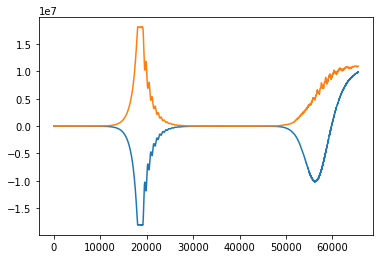

In [23]:
times = np.arange(0,Nt)
plt.plot(times, r1[0,:], times, r2[0,:])

In [24]:
np.amin(np.abs(r1[0,:]-r2[0,:]))

5.0

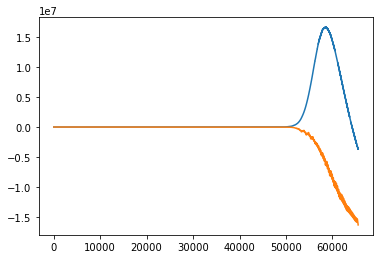

In [25]:
plt.plot(times, r1[2,:], times, r2[2,:])

V2s does some weird stuff


- small step size: does not solve the instabilities
- different integrator?
- pseudo-inverse numerical problems/incorrect?
- directSolve wrong? (ie solved linear system incorrectly?)
- simulation above wrong?
- matrix elements wrong - signs etc)

In [ ]:
# x vs y as in Ishikawa's paper
plt.plot(r1[0,:], r1[1,:], label='one')
plt.plot(r2[0,:], r2[1,:], label='two')
plt.legend()